In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from dataset import LayoutDataset
from models import LayoutMLP
from scipy.stats import kendalltau

2023-10-18 16:23:53.296031: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-18 16:23:54.234224: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
batch_size = 128
learning_rate = 1e-4
batch_per_file_size = 8
decay_rate = 0.95
node_embedding_size = 20
layers = [48, 32, 24, 16]

dataset = LayoutDataset(
    batch_size, train_sample_fraction=1.0,
    subset='xla:default', build_tfrecords=False,
    batch_per_file_size=batch_per_file_size
)

2023-10-18 16:23:56.804298: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-18 16:23:56.910480: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-18 16:23:56.910730: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [3]:
mlp = LayoutMLP(
    batch_size,
    learning_rate=learning_rate,
    mask_max_len=dataset.n_config_nodes_upper_limit,
    batch_per_file_size=batch_per_file_size,
    decay_rate=decay_rate,
    node_embedding_size=node_embedding_size,
    validation_frequency=10_000,
    validations_without_improvement=3,
    layer_sizes=layers,
    loss='pairwise_hinge',
    l1_multiplier=5e-10,
    n_siblings=dataset.n_siblings
)

mlp.train(dataset, None)

2023-10-18 16:25:05.140262: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-10-18 16:25:05.153891: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f3138c69200 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-18 16:25:05.153920: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2023-10-18 16:25:05.166972: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-18 16:25:05.374090: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-10-18 16:25:05.484568: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifeti

iteration 500 training loss 3.229097 lr 0.00010
iteration 1000 training loss 3.1849456 lr 0.00010
iteration 1500 training loss 3.105328 lr 0.00010
iteration 2000 training loss 3.0822904 lr 0.00010
iteration 2500 training loss 3.1016617 lr 0.00010
iteration 3000 training loss 3.1755316 lr 0.00010
iteration 3500 training loss 3.099691 lr 0.00010
iteration 4000 training loss 3.059149 lr 0.00010
iteration 4500 training loss 3.0683866 lr 0.00010
iteration 5000 training loss 3.1380486 lr 0.00010
iteration 5500 training loss 2.9352098 lr 0.00010
iteration 6000 training loss 3.0927842 lr 0.00010
iteration 6500 training loss 3.0683284 lr 0.00010
iteration 7000 training loss 2.6012437 lr 0.00010
iteration 7500 training loss 2.7917619 lr 0.00010
iteration 8000 training loss 2.8498101 lr 0.00010
iteration 8500 training loss 2.9778936 lr 0.00010
iteration 9000 training loss 2.937625 lr 0.00010
iteration 9500 training loss 2.8858538 lr 0.00010
iteration 10000 training loss 2.9352317 lr 0.00010
layou

## Evaluate validation set

In [4]:
val_df = mlp.predict_over_dataset(dataset.valid_data, return_labels=True)

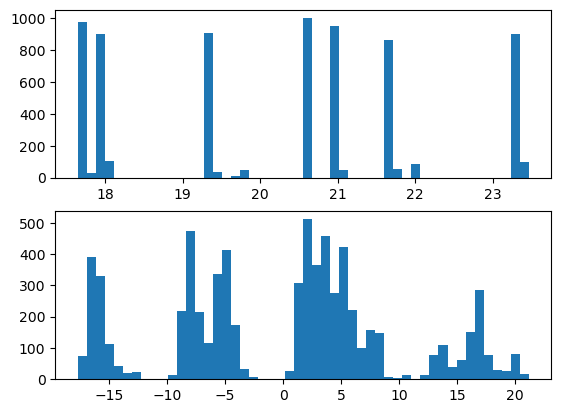

In [5]:
plt.subplot(2, 1, 1)
plt.hist(val_df['target'], bins=50)
plt.subplot(2, 1, 2)
plt.hist(val_df['prediction'], bins=50);

In [6]:
val_df.groupby('ID').apply(lambda x: x.min()).sort_values('prediction')

,ID,config_index,prediction,target
ID,,,,
b'layout:xla:default:bert_pretraining.4x4.fp16',b'layout:xla:default:bert_pretraining.4x4.fp16',49,-17.726112,17.647207
b'layout:xla:default:tf2_bert_pretrain_dynamic_batch_size',b'layout:xla:default:tf2_bert_pretrain_dynamic...,18,-9.590538,17.943745
b'layout:xla:default:mlperf_bert_batch_24_2x2',b'layout:xla:default:mlperf_bert_batch_24_2x2',0,-6.881887,23.313332
b'layout:xla:default:resnet_v1_50_official_batch_128_bf16',b'layout:xla:default:resnet_v1_50_official_bat...,2,0.220915,20.910105
b'layout:xla:default:resnet50.4x4.fp16',b'layout:xla:default:resnet50.4x4.fp16',18,0.473526,19.288345
b'layout:xla:default:inception_v3_batch_128_train',b'layout:xla:default:inception_v3_batch_128_tr...,1,4.274539,21.680332
b'layout:xla:default:unet_3d.4x4.bf16',b'layout:xla:default:unet_3d.4x4.bf16',0,9.781157,20.629904


Text(0.5, 1.0, "b'layout:xla:default:tf2_bert_pretrain_dynamic_batch_size'")

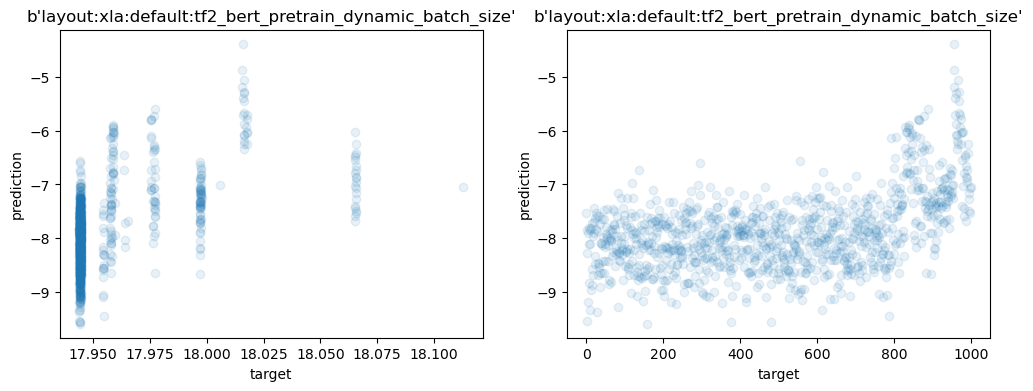

In [17]:
x_lin = np.linspace(15, 25, 100)
#plt.plot(x_lin, x_lin, color='orange')

#random_sample = val_df.sample(1_000)
graph_id = np.random.choice(val_df['ID'].unique())
#graph_id = b'layout:xla:default:inception_v3_batch_128_train'
random_sample = val_df[val_df['ID'] == graph_id].copy()

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.scatter(
    random_sample.target,
    np.clip(random_sample.prediction, a_min=-500.0, a_max=1000.0),
    alpha=0.1,
    #c=random_sample['ID'].apply(lambda x: x.decode('UTF-8').split(':')[1] == 'xla').values.astype(float)
)
plt.xlabel('target')
plt.ylabel('prediction')
plt.title(graph_id)
#plt.colorbar()

random_sample.sort_values('target', inplace=True)
plt.subplot(1, 2, 2)
plt.scatter(
    np.arange(len(random_sample)),
    np.clip(random_sample.prediction, a_min=-500.0, a_max=1000.0),
    alpha=0.1,
    #c=random_sample['ID'].apply(lambda x: x.decode('UTF-8').split(':')[1] == 'xla').values.astype(float)
)
plt.xlabel('target')
plt.ylabel('prediction')
plt.title(graph_id)
#plt.colorbar()

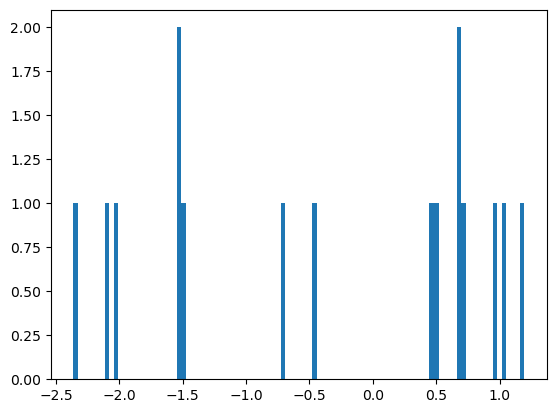

In [18]:
plt.hist(mlp.dense_layer_global_3.kernel.numpy().flatten(), bins=100);

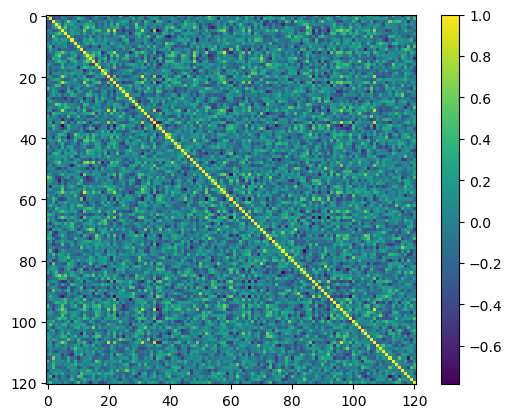

In [19]:
emb = mlp.embedding_layer_node_ops.weights[0].numpy()
emb = emb / np.expand_dims(np.linalg.norm(emb, axis=1), axis=-1)
dots = np.matmul(emb, emb.T)
plt.imshow(dots)
plt.colorbar()

In [ ]:
dots[34, 26]

In [ ]:
np.argsort(dots[34])

In [ ]:
ind = np.unravel_index(np.argsort(dots.flatten())[2], dots.shape)
ind

In [ ]:
val_df[val_df['ID'] == b'layout:xla:default:unet_3d.4x4.bf16'].sort_values('target')

In [ ]:
for val_batch in dataset.valid_data:
    if b'layout:xla:default:mlperf_bert_batch_24_2x2' in val_batch['layout_id'].numpy():
        print(val_batch['layout_id'])
        break

In [ ]:
np.unique(val_batch['layout_id'].numpy())

In [ ]:
b'layout:xla:default:mlperf_bert_batch_24_2x2' in val_batch['layout_id'].numpy()

In [ ]:
layout_ids = val_batch['layout_id']
config_descriptor = val_batch['node_descriptor']
valid_mask = val_batch['valid_nodes']
graph_descriptor = val_batch['graph_descriptor']

with tf.device('/cpu:0'):
    subset_info_str = tf.map_fn(
        lambda layout_id: tf.strings.reduce_join(
            tf.strings.split(layout_id, ":")[:3]),
        layout_ids
    )

subset_info = mlp.text_vectorization(subset_info_str)
subset_info = tf.expand_dims(subset_info, axis=-1)
subset_info = mlp.embedding_layer_subset_info(subset_info)
subset_info = subset_info[:, 0, :]

# for si, sn in zip(subset_info_str.numpy(), subset_info.numpy()):
#     print(si, sn)

node_operations = config_descriptor[:, :, -1]
config_descriptor = config_descriptor[:, :, :-1]
node_operations = tf.cast(node_operations, tf.int32)
# node_operations.shape == (batch_size, mask_max_len)                                                                                                                                 
node_embedding = mlp.embedding_layer_node_ops(node_operations)
# node_embedding.shape == (batch_size, mask_max_len, embed_len)
# np.unique(node_operations.numpy().flatten(), return_counts=True)

x = mlp.normalization_layer_config_nodes(config_descriptor)
normal_graph_descriptor = mlp.normalization_layer_graph_descriptor(graph_descriptor)
x = tf.concat([x, node_embedding], axis=-1)

x = mlp.dense_layer_node_1(x)
x = mlp.relu_layer(x)  # (batch_size, n_config_nodes_upper_limit, n_units)                                                                                                           
x = mlp.dense_layer_node_2(x)
x = mlp.relu_layer(x)  # (batch_size, n_config_nodes_upper_limit, n_units)                                                                                                           

# plt.hist(x.numpy().flatten(), bins=100);
float_mask = tf.sequence_mask(valid_mask, mlp.mask_max_len, dtype=tf.float32)
# (batch_size, n_config_nodes_upper_limit)                                                                                                                                            

float_mask = tf.expand_dims(float_mask, axis=-1)
x = x * float_mask

x = tf.reduce_sum(x, axis=1)
#plt.subplot(2, 1, 1)
#plt.hist(x.numpy().flatten(), bins=100);

x = x / tf.expand_dims(tf.cast(valid_mask, tf.float32), axis=-1)
#plt.subplot(2, 1, 2)
#plt.hist(x.numpy().flatten(), bins=100);
for i, lid, gd, nd in zip(range(96), layout_ids.numpy(), graph_descriptor.numpy(), normal_graph_descriptor.numpy()):
    if i in [19]:
        print(i, gd[80:90], nd[80:90], lid)
x = tf.concat([x, normal_graph_descriptor, subset_info], axis=-1)
#plt.hist(x.numpy().flatten(), bins=100);
x = mlp.dense_layer_global_1(x)
x = mlp.relu_layer(x)
#plt.hist(x.numpy().flatten(), bins=100);
x = mlp.dense_layer_global_2(x)
x = mlp.relu_layer(x)
#plt.hist(x.numpy().flatten(), bins=100);
x = mlp.dense_layer_global_3(x)
x = tf.reshape(x, (-1,))
x

In [ ]:
random_sample = val_df.sample(5_000)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.scatter(
    random_sample['target'],
    np.abs(random_sample['target'] - random_sample['prediction']),
    alpha=0.07
)
plt.xlabel('target')
plt.ylabel('abs error')
x_lin = np.linspace(0, 0.7, 100)
#plt.plot(x_lin, x_lin, color='orange')


plt.subplot(1, 2, 2)
plt.scatter(
    random_sample['target'],
    np.square(random_sample['target'] - random_sample['prediction']),
    alpha=0.07
)
plt.xlabel('target')
plt.ylabel('squared error')

In [20]:
def sort_configs(df):
    top = df.sort_values('prediction')
    top = top['config_index'].values.tolist()
    top = [str(i) for i in top]
    return ';'.join(top)

val_prediction = val_df.groupby('ID').apply(sort_configs)
val_prediction.rename(index=lambda x: x.decode('UTF-8'), inplace=True)
val_prediction

ID
layout:xla:default:bert_pretraining.4x4.fp16               11422;5380;15282;15120;15355;11716;10682;11360...
layout:xla:default:inception_v3_batch_128_train            1379;3399;3362;3423;4944;217;5691;4967;943;139...
layout:xla:default:mlperf_bert_batch_24_2x2                3461;3550;4141;3459;782;3588;164;5418;2792;417...
layout:xla:default:resnet50.4x4.fp16                       5883;579;5073;1468;596;227;4247;894;4260;567;8...
layout:xla:default:resnet_v1_50_official_batch_128_bf16    4860;2055;6202;5998;7366;7366;1670;7216;7393;2...
layout:xla:default:tf2_bert_pretrain_dynamic_batch_size    10210;6166;72;6280;9046;10793;3001;10512;6177;...
layout:xla:default:unet_3d.4x4.bf16                        823;823;339;486;391;449;396;396;1389;1389;61;4...
dtype: object

In [ ]:
val_df

In [ ]:
val_df['ID'].map(lambda x: ':'.join(x.decode('UTF-8').split(':')[:3])).unique()

In [21]:
def compute_layout_score_group(df):
    score, _ = kendalltau(df['prediction'], df['target'])
    return score

val_df['subset'] = val_df['ID'].map(lambda x: ':'.join(x.decode('UTF-8').split(':')[:3]))
for subset in val_df['subset'].unique():
    mean = np.mean(val_df[val_df['subset'] == subset].groupby('ID').apply(compute_layout_score_group))
    print(subset, mean)

layout:xla:default 0.2647693017701611


In [22]:
val_scores = val_df.groupby('ID').apply(compute_layout_score_group)
val_scores.sort_values()

ID
b'layout:xla:default:unet_3d.4x4.bf16'                       -0.078286
b'layout:xla:default:resnet_v1_50_official_batch_128_bf16'    0.206094
b'layout:xla:default:mlperf_bert_batch_24_2x2'                0.233809
b'layout:xla:default:tf2_bert_pretrain_dynamic_batch_size'    0.288910
b'layout:xla:default:bert_pretraining.4x4.fp16'               0.343435
b'layout:xla:default:inception_v3_batch_128_train'            0.426973
b'layout:xla:default:resnet50.4x4.fp16'                       0.432451
dtype: float64

In [ ]:
np.mean([0.368, 0.137, 0.738, 0.346, 0.85])

In [ ]:
def layout_score(candidate_order, layout_dict):
    runtimes = layout_dict['config_runtime']
    best_ranking = np.argsort(runtimes)
    assert len(candidate_order) == len(runtimes)
    score, _ = kendalltau(candidate_order, best_ranking)
    return score

In [ ]:
dirpath, filename

In [ ]:
true_order = np.argsort(layout_dict['config_runtime'])
plt.scatter(true_order, candidate_order)

In [ ]:
layout_set = 'valid'
true_orders = []
layout_ids = []
for dirpath, dirnames, filenames in os.walk('predict-ai-model-runtime/npz_all/npz/layout'):
    if len(filenames) == 0:
        continue
    
    if dirpath.split('/')[-1] != layout_set:
        continue
        
    layout_id_prefix = ':'.join(dirpath.split('/')[-4:-1])
    for filename in os.listdir(dirpath):
        print(filename)
        layout_id = layout_id_prefix+':'+filename[:-4]
        layout_dict = dict(np.load(os.path.join(dirpath, filename)))
        runtimes = layout_dict['config_runtime']
        best_ranking = np.argsort(runtimes)
        best_ranking = ';'.join([str(i) for i in best_ranking])
        true_orders.append(best_ranking)
        layout_ids.append(layout_id)
        
true_order_df = pd.DataFrame(
    data=np.stack([layout_ids, true_orders], axis=-1),
    columns=['ID', 'true_order']
)
true_order_df

In [ ]:
# layout_id = true_order_df.sample()['ID'].values[0]
layout_id = 'layout:xla:default:resnet50.4x4.fp16'
true_order = [int(i) for i in true_order_df[true_order_df['ID'] == layout_id]['true_order'].values[0].split(';')]
candidate_order = [int(i) for i in val_prediction[layout_id].split(';')]

plt.scatter(true_order, candidate_order)
plt.xlabel('true order')
plt.ylabel('candidate order')
plt.title(f'{layout_id}, len {len(true_order)}')

In [ ]:
layout_dict = dict(np.load('predict-ai-model-runtime/npz_all/npz/layout/nlp/default/valid/small_bert_bert_en_uncased_L-6_H-256_A-4_batch_size_16_train.npz'))
layout_dict['node_config_feat'].shape

In [ ]:
val_df[val_df['ID'] == b'layout:nlp:default:small_bert_bert_en_uncased_L-6_H-256_A-4_batch_size_16_train']

In [ ]:
evaluation_result_layout['score'].astype(float).mean()

## Inference over test set

In [23]:
test_df = mlp.predict_over_dataset(dataset.test_data, return_labels=False)
test_df

,ID,config_index,prediction
0,b'layout:xla:default:fbaa8bb6a1aed9988281085c9...,8,-5.115569
1,b'layout:xla:default:5335ed13823b0a518ee3c79ba...,9,4.482114
2,b'layout:xla:default:cd708819d3f5103afd6460b15...,6,-20.723906
3,b'layout:xla:default:3e7156ac468dfb75cf5c9615e...,5,-10.973804
4,b'layout:xla:default:3e7156ac468dfb75cf5c9615e...,10,-10.188032
...,...,...,...
7995,b'layout:xla:default:e8a3a1401b5e79f66d7037e42...,998,-1.284058
7996,b'layout:xla:default:937ee0eb0d5d6151b7b825293...,986,7.213422
7997,b'layout:xla:default:e8a3a1401b5e79f66d7037e42...,996,1.008826
7998,b'layout:xla:default:e8a3a1401b5e79f66d7037e42...,999,-4.031484


In [24]:
test_prediction = test_df.groupby('ID').apply(sort_configs)
test_prediction.rename(index=lambda x: x.decode('UTF-8'), inplace=True)
test_prediction

ID
layout:xla:default:05ae41e26dd3c4c06390371a0423233c    731;96;498;483;97;323;131;148;254;400;481;358;...
layout:xla:default:3e7156ac468dfb75cf5c9615e1e5887d    864;388;969;320;96;697;490;865;22;936;221;647;...
layout:xla:default:5335ed13823b0a518ee3c79ba4425f34    710;227;296;542;706;666;199;999;766;320;902;30...
layout:xla:default:937ee0eb0d5d6151b7b8252933b5c1c9    73;254;698;881;231;340;140;4;670;281;51;879;89...
layout:xla:default:cd708819d3f5103afd6460b15e74eaf3    29;718;554;823;316;321;760;161;305;210;73;419;...
layout:xla:default:db59a991b7c607634f13570d52ce885f    587;708;418;477;120;300;147;410;162;934;519;74...
layout:xla:default:e8a3a1401b5e79f66d7037e424f3b6df    900;816;699;215;204;41;415;46;99;470;802;405;5...
layout:xla:default:fbaa8bb6a1aed9988281085c91065c05    542;425;286;89;949;863;31;150;461;959;289;110;...
dtype: object

In [25]:
pd.DataFrame(test_prediction, columns=['TopConfigs']).to_csv('layout_xla_default_test_prediction_10_18_17_48.csv')

In [ ]:
plt.hist(np.abs(mlp.dense_layer_1.kernel.numpy().flatten()), bins=50)